In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('white')
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(10, 4))
sns.set(font_scale=1.2)
plt.style.use('seaborn-whitegrid')

def jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [3]:
start='1/1/2018'
end='7/2/2020'
start_dt = datetime.strptime(start, "%d/%m/%Y")
end_dt = datetime.strptime(end, "%d/%m/%Y")

In [4]:
data = pd.date_range(start=start, end=end)
data = pd.DataFrame({'date': data})
data = data.set_index('date')
print(len(data))

914


In [5]:
# sales and price

In [6]:
path = Path('data/sales/sales_200208.csv')
sales_raw = pd.read_csv(path, index_col=0)
sales_raw.index = pd.to_datetime(sales_raw.index.str[:-19], format="%d %b %Y")
sales_raw = sales_raw.loc[sales_raw.sku != 'MZ-HEIN-T9VC']
sales_raw.drop('sku', inplace=True, axis=1)
sales_raw.head()

,type,product sales,total,quantity
date,,,,
2018-02-02,Service Fee,0.00,-30.00,NaN
2018-02-06,Debt,0.00,259.93,NaN
2018-02-09,Order,24.99,1.11,1.0
2018-02-10,Order,24.99,2.01,1.0
2018-02-11,Order,24.99,17.51,1.0


In [7]:
sales_raw.tail()

,type,product sales,total,quantity
date,,,,
2020-02-07,Order,29.99,21.37,1.0
2020-02-07,Order,29.99,21.37,1.0
2020-02-07,Order,29.99,21.37,1.0
2020-02-07,Order,59.98,42.75,2.0
2020-02-07,Order,29.99,21.37,1.0


In [8]:
sales = sales_raw.loc[sales_raw['type'] == 'Order']
sales.drop(['type', 'total'], axis=1, inplace=True)
sales.columns = ['price', 'quantity']
# sales.quantity.fillna(0, inplace=True)
sales.price = sales.price / sales.quantity
sales = sales.groupby(sales.index).agg({'price': 'mean', 'quantity': 'sum'})
sales.head()

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,price,quantity
date,,
2018-02-09,24.99,1.0
2018-02-10,24.99,1.0
2018-02-11,24.99,2.0
2018-02-12,24.99,2.0
2018-02-13,24.99,2.0


In [9]:
data = pd.merge(data, sales, how='outer', left_index=True, right_index=True)
data.price.fillna(method='ffill', inplace=True)
data.price.fillna(method='bfill', inplace=True)
data.quantity.fillna(0, inplace=True)
data = data.loc[(data.index >= start_dt) & (data.index <= end_dt)]
print(len(data))

768


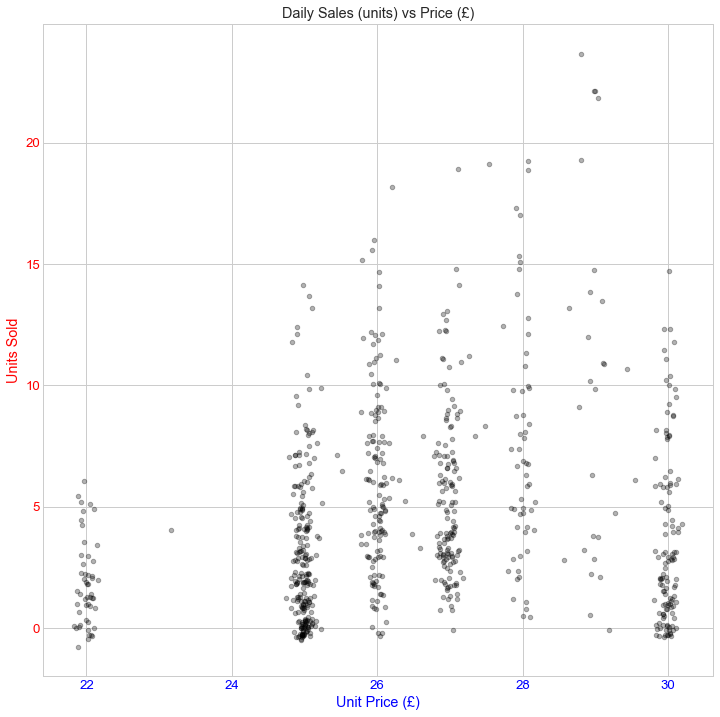

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_title('Daily Sales (units) vs Price (£)')
ax.scatter(jitter(data.price), jitter(data.quantity), s=20, alpha=.3, c='black')
ax.set_xlabel('Unit Price (£)', color='blue')
ax.tick_params(axis='x', labelcolor='blue')
ax.set_ylabel('Units Sold', color='red')
ax.tick_params(axis='y', labelcolor='red')

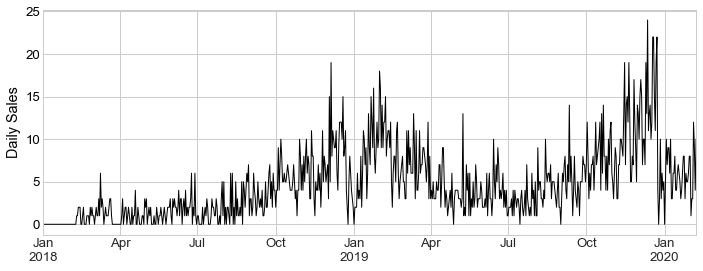

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))

# ax.set_title('Daily Sales (units) & Price (£) over time')
data.quantity.plot(ax=ax, color='black', linewidth=1)
ax.set_ylabel('Daily Sales', color='black')
ax.tick_params(axis='y', labelcolor='black')

ax.set_xlabel(None)
plt.tight_layout()

In [12]:
fig.savefig('outputs/sales-time.png')

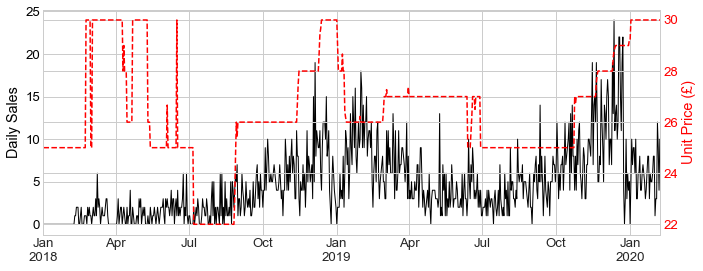

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))

# ax.set_title('Daily Sales (units) & Price (£) over time')
data.quantity.plot(ax=ax, color='black', linewidth=1)
ax.set_ylabel('Daily Sales', color='black')
ax.tick_params(axis='y', labelcolor='black')

ax2 = ax.twinx()
data.price.plot(ax=ax2, color='red', linestyle='--')
ax2.set_ylabel('Unit Price (£)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

ax.set_xlabel(None)
plt.tight_layout()

# ax1 = plt.axes()
# ax1.xaxis.set_label_text('foo')
# ax1.xaxis.label.set_visible(False)


In [14]:
fig.savefig('outputs/sales-price-time.png')

In [15]:
# advertising

In [16]:
def distribute_periodic_cost_back(series):
    """
    Fill NAN using back-fill, adjusting fill value for length of fill required.
    """
    i = 0
    while i < len(series):
        n = series.iloc[i]
        if np.isnan(n):
            # look forward
            ii = i + 1
            found = None
            while not found:
                if ii == len(series):
                    # reached end
                    break
                n = series.iloc[ii]

                if not np.isnan(n):
                    found = n
                else:
                    ii += 1
            if found:
                count = ii - i
                for iii in range(i, ii + 1):
                    series.iloc[iii] = float(found / count)

            i = ii

        i += 1
    return series

In [17]:
advertising = sales_raw.loc[sales_raw['type'] == 'Advert']
advertising.drop(['type', 'product sales', 'quantity'], axis=1, inplace=True)
advertising.columns = ['advertising']
advertising = advertising.groupby(advertising.index).sum()

# need to apply 50% adjustment from september
mask = advertising.index >= '2019-09-02'
advertising.advertising.loc[mask] = advertising.advertising.loc[mask] / 2

In [18]:
data = pd.merge(data, advertising, how='outer', left_index=True, right_index=True)
data.advertising = distribute_periodic_cost_back(data.advertising)
data.advertising.fillna(method='ffill', inplace=True)
data.advertising = -data.advertising
data = data.loc[(data.index >= start_dt) & (data.index <= end_dt)]
print(len(data))

768


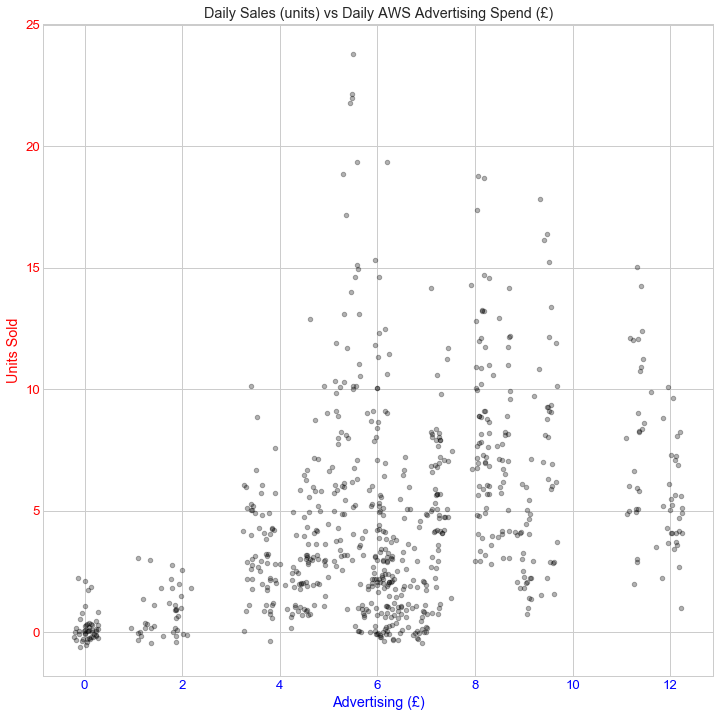

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.set_title('Daily Sales (units) vs Daily AWS Advertising Spend (£)')
ax.scatter(jitter(data.advertising), jitter(data.quantity), s=20, alpha=.3, c='black')
ax.set_xlabel('Advertising (£)', color='blue')
ax.tick_params(axis='x', labelcolor='blue')
ax.set_ylabel('Units Sold', color='red')
ax.tick_params(axis='y', labelcolor='red')


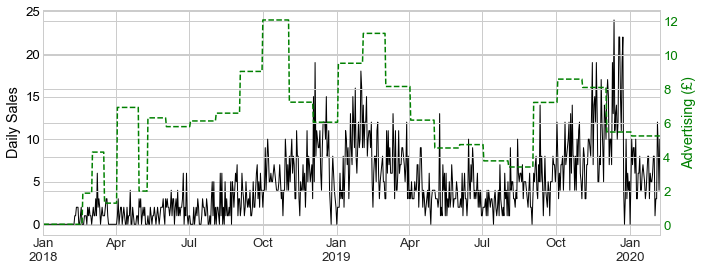

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# ax[1].set_title('Daily Sales (units) vs Daily AWS Advertising Spend (£) over time')

data.quantity.plot(ax=ax, color='black', linewidth=1)
ax.set_ylabel('Daily Sales', color='black')
ax.tick_params(axis='y', labelcolor='black')

ax2 = ax.twinx()
data.advertising.plot(ax=ax2, color='green', linestyle='--')
ax2.set_ylabel('Advertising (£)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

ax.set_xlabel(None)
plt.tight_layout()

In [21]:
fig.savefig('outputs/sales-advertising-time.png')

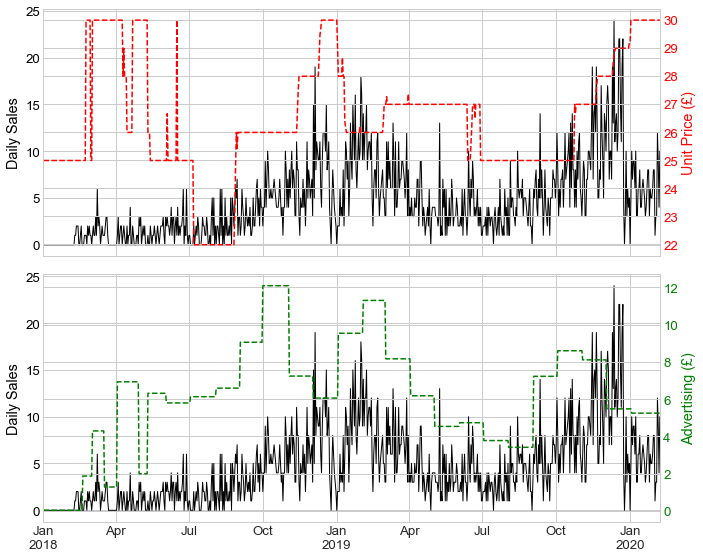

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

data.quantity.plot(ax=ax[0], color='black', linewidth=1)
ax[0].set_ylabel('Daily Sales', color='black')
ax[0].tick_params(axis='y', labelcolor='black')

ax2 = ax[0].twinx()
data.price.plot(ax=ax2, color='red', linestyle='--')
ax2.set_ylabel('Unit Price (£)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

data.quantity.plot(ax=ax[1], color='black', linewidth=1)
ax[1].set_ylabel('Daily Sales', color='black')
ax[1].tick_params(axis='y', labelcolor='black')

ax22 = ax[1].twinx()
data.advertising.plot(ax=ax22, color='green', linestyle='--')
ax22.set_ylabel('Advertising (£)', color='green')
ax22.tick_params(axis='y', labelcolor='green')

ax[1].set_xlabel(None)
plt.tight_layout()

In [23]:
fig.savefig('outputs/sales-price-advertising-time.png')

In [24]:
# weather

In [25]:
path = Path('data/weather/daily.csv')
weather_raw = pd.read_csv(path)
weather_raw['date'] = pd.to_datetime(weather_raw[['Year', 'Month', 'Day']])
weather_raw.drop(['Year', 'Month', 'Day', 'temp_max', 'temp_min'], axis=1, inplace=True)
weather_raw.set_index('date', inplace=True)
weather_raw.temp_av = (weather_raw.temp_av - 32) * 5 / 9

In [26]:
data = pd.merge(data, weather_raw, how='outer', left_index=True, right_index=True)

In [27]:
data.temp_av.fillna(method='bfill', inplace=True)
data.temp_av.fillna(method='ffill', inplace=True)
data = data.loc[(data.index >= start_dt) & (data.index <= end_dt)]
print(len(data))

768


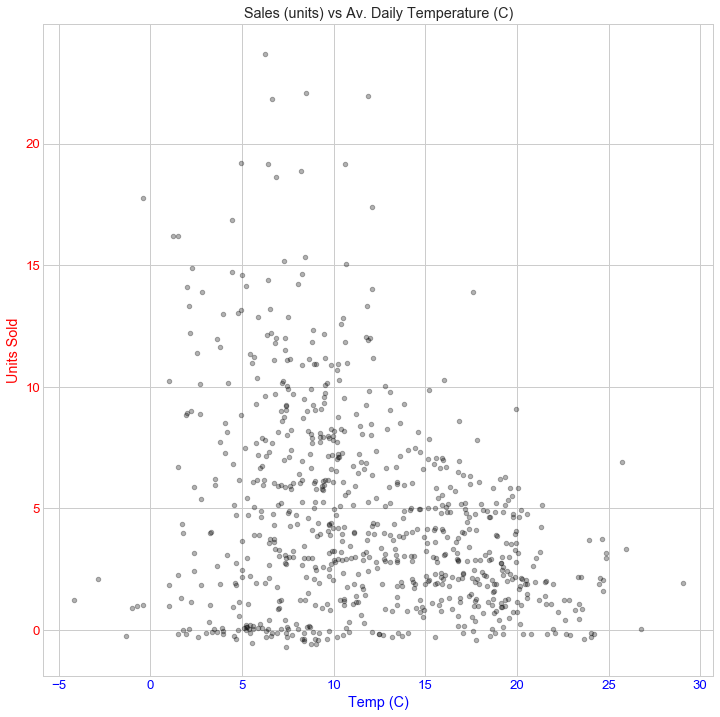

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

ax.set_title('Sales (units) vs Av. Daily Temperature (C)')
ax.scatter(jitter(data.temp_av), jitter(data.quantity), s=20, alpha=.3, c='black')
ax.set_xlabel('Temp (C)', color='blue')
ax.tick_params(axis='x', labelcolor='blue')
ax.set_ylabel('Units Sold', color='red')
ax.tick_params(axis='y', labelcolor='red')

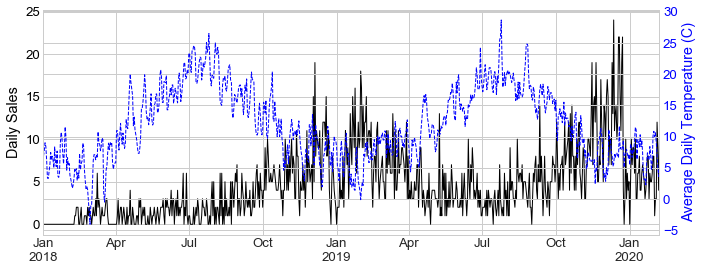

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

data.quantity.plot(ax=ax, color='black', linewidth=1)
ax.set_ylabel('Daily Sales', color='black')
ax.tick_params(axis='y', labelcolor='black')

ax2 = ax.twinx()
data.temp_av.plot(ax=ax2, color='blue', linewidth=1, linestyle='--')
ax2.set_ylabel('Average Daily Temperature (C)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax.set_xlabel(None)
plt.tight_layout()

In [30]:
fig.savefig('outputs/sales-temperature-time.png')

In [31]:
# Review score

In [32]:
# own reviews

In [33]:
path = Path('data/reviews/reviews.csv')
reviews_raw = pd.read_csv(path, index_col=0)
reviews_raw = reviews_raw[['rating', 'date']]
reviews_raw.columns = ['score', 'date']
reviews_raw.date = pd.to_datetime(reviews_raw.date, format="%d/%m/%Y")
reviews_raw.score = reviews_raw.score - 3
reviews_raw = reviews_raw.groupby(by='date').sum()

reviews_raw.head()

,score
date,
2018-02-13,4
2018-02-14,2
2018-02-15,2
2018-02-16,2
2018-02-19,1


In [34]:
# competitors
for i in range(1,9):
    path = Path(f'data/reviews/{str(i)}.csv')
    competitor_df = pd.read_csv(path, index_col=0)
    competitor_df = competitor_df[['rating', 'date']]
    competitor_df.date = pd.to_datetime(competitor_df.date, format="%d/%m/%Y")
    competitor_df.rating = competitor_df.rating - 3
    competitor_df = competitor_df.groupby(by='date').sum()
    competitor_df.columns = [f'{i}_score']
    
    reviews_raw = pd.merge(reviews_raw, competitor_df, how='outer', left_index=True, right_index=True)

reviews_raw.fillna(0, inplace=True)   

In [35]:
competitor_cols = ['1_score', '2_score', '3_score', '4_score', '5_score', '6_score', '7_score', '8_score']
reviews_raw['comp_score'] = reviews_raw[competitor_cols].sum(axis=1)

reviews_raw.drop(competitor_cols, axis=1, inplace=True)

reviews_raw.head()

,score,comp_score
date,,
2017-02-04,0.0,0.0
2017-02-05,0.0,2.0
2017-02-06,0.0,2.0
2017-02-07,0.0,1.0
2017-02-10,0.0,-3.0


In [36]:
data = pd.merge(data, reviews_raw, how='outer', left_index=True, right_index=True) 
data = data[(data.index >= start_dt) & (data.index <= end_dt)]
data.fillna(0, inplace=True) 
data['score_accum'] = data.score.cumsum()
data['comp_score_accum'] = data.comp_score.cumsum()
data['score_ratio'] = data.score_accum / data.comp_score_accum
data.fillna(0, inplace=True)  

data.head()

,price,quantity,advertising,temp_av,score,comp_score,score_accum,comp_score_accum,score_ratio
date,,,,,,,,,
2018-01-01,24.99,0.0,0.040417,6.833333,0.0,0.0,0.0,0.0,0.0
2018-01-02,24.99,0.0,0.040417,7.722222,0.0,2.0,0.0,2.0,0.0
2018-01-03,24.99,0.0,0.040417,9.000000,0.0,0.0,0.0,2.0,0.0
2018-01-04,24.99,0.0,0.040417,8.388889,0.0,0.0,0.0,2.0,0.0
2018-01-05,24.99,0.0,0.040417,6.166667,0.0,0.0,0.0,2.0,0.0


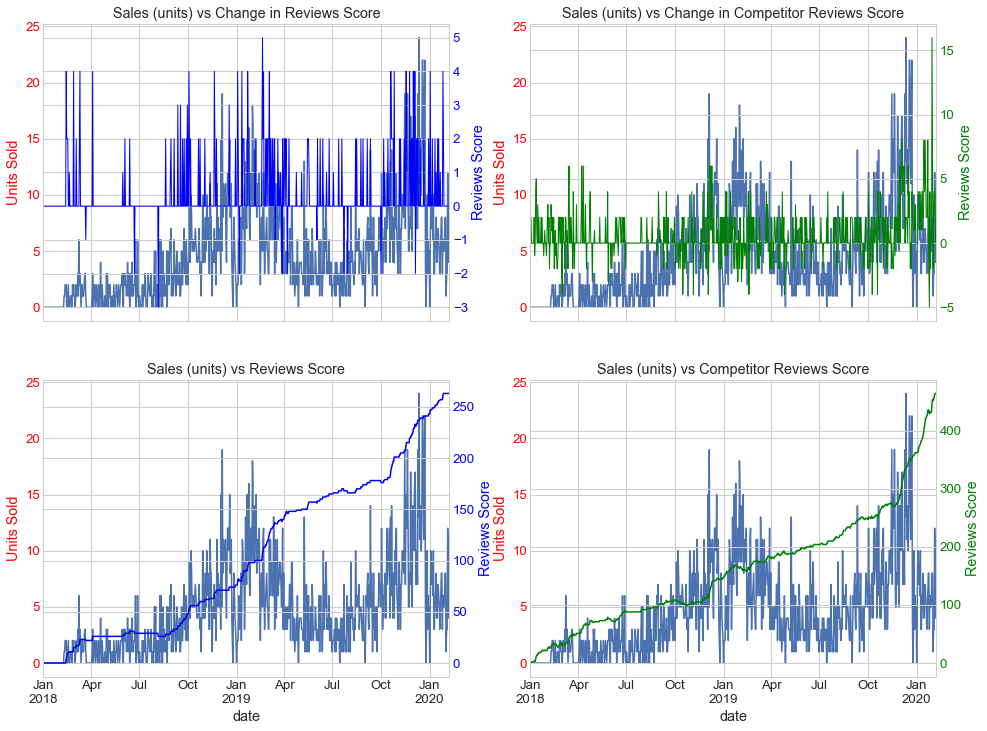

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

ax[0][0].set_title('Sales (units) vs Change in Reviews Score')

data.quantity.plot(ax=ax[0][0])
ax[0][0].set_ylabel('Units Sold', color='red')
ax[0][0].tick_params(axis='y', labelcolor='red')
ax00 = ax[0][0].twinx()
data.score.plot(ax=ax00, color='blue', linewidth=1)
ax00.set_ylabel('Reviews Score', color='blue')
ax00.tick_params(axis='y', labelcolor='blue')

ax[0][1].set_title('Sales (units) vs Change in Competitor Reviews Score')
ax01 = ax[0][1].twinx()
data.quantity.plot(ax=ax[0][1])
ax[0][1].set_ylabel('Units Sold', color='red')
ax[0][1].tick_params(axis='y', labelcolor='red')

data.comp_score.plot(ax=ax01, color='green', linewidth=1)
ax01.set_ylabel('Reviews Score', color='green')
ax01.tick_params(axis='y', labelcolor='green')


ax[1][0].set_title('Sales (units) vs Reviews Score')
data.quantity.plot(ax=ax[1][0])
ax[1][0].set_ylabel('Units Sold', color='red')
ax[1][0].tick_params(axis='y', labelcolor='red')
ax10 = ax[1][0].twinx()
data.score_accum.plot(ax=ax10, color='blue')
ax10.set_ylabel('Reviews Score', color='blue')
ax10.tick_params(axis='y', labelcolor='blue')

ax[1][1].set_title('Sales (units) vs Competitor Reviews Score')
ax11 = ax[1][1].twinx()
data.quantity.plot(ax=ax[1][1])
ax[1][1].set_ylabel('Units Sold', color='red')
ax[1][1].tick_params(axis='y', labelcolor='red')

data.comp_score_accum.plot(ax=ax11, color='green')
ax11.set_ylabel('Reviews Score', color='green')
ax11.tick_params(axis='y', labelcolor='green')

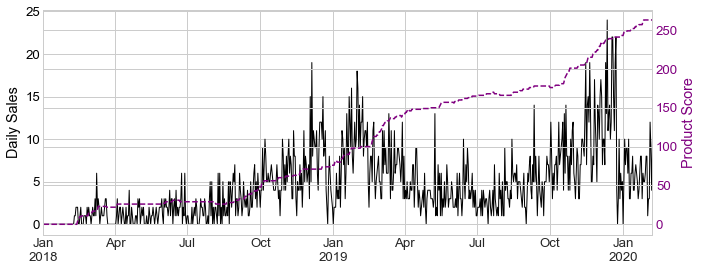

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

data.quantity.plot(ax=ax, color='black', linewidth=1)
ax.set_ylabel('Daily Sales', color='black')
ax.tick_params(axis='y', labelcolor='black')

ax2 = ax.twinx()
data.score_accum.plot(ax=ax2, color='purple', linestyle='--')
ax2.set_ylabel('Product Score', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

ax.set_xlabel(None)
plt.tight_layout()

In [120]:
fig.savefig('outputs/sales-score-time.png')

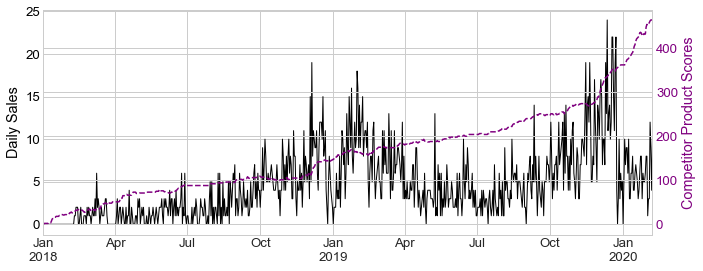

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

data.quantity.plot(ax=ax, color='black', linewidth=1)
ax.set_ylabel('Daily Sales', color='black')
ax.tick_params(axis='y', labelcolor='black')

ax2 = ax.twinx()
data.comp_score_accum.plot(ax=ax2, color='purple', linestyle='--')
ax2.set_ylabel('Competitor Product Scores', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

ax.set_xlabel(None)
plt.tight_layout()

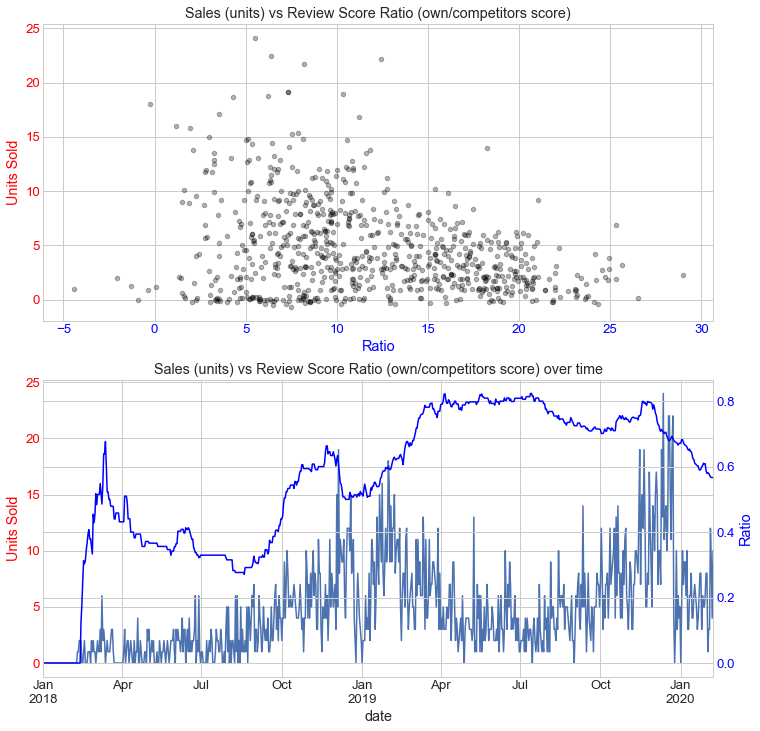

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].set_title('Sales (units) vs Review Score Ratio (own/competitors score)')
ax[0].scatter(jitter(data.temp_av), jitter(data.quantity), s=20, alpha=.3, c='black')
ax[0].set_xlabel('Ratio', color='blue')
ax[0].tick_params(axis='x', labelcolor='blue')
ax[0].set_ylabel('Units Sold', color='red')
ax[0].tick_params(axis='y', labelcolor='red')

ax[1].set_title('Sales (units) vs Review Score Ratio (own/competitors score) over time')
data.quantity.plot(ax=ax[1])
ax[1].set_ylabel('Units Sold', color='red')
ax[1].tick_params(axis='y', labelcolor='red')
ax2 = ax[1].twinx()
data.score_ratio.plot(ax=ax2, color='blue')
ax2.set_ylabel('Ratio', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

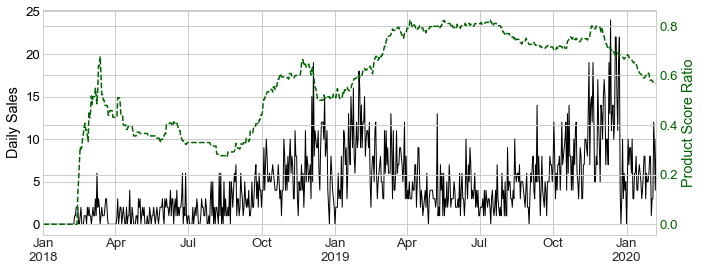

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

data.quantity.plot(ax=ax, color='black', linewidth=1)
ax.set_ylabel('Daily Sales', color='black')
ax.tick_params(axis='y', labelcolor='black')

ax2 = ax.twinx()
data.score_ratio.plot(ax=ax2, color='darkgreen', linestyle='--')
ax2.set_ylabel('Product Score Ratio', color='darkgreen')
ax2.tick_params(axis='y', labelcolor='darkgreen')

ax.set_xlabel(None)
plt.tight_layout()

In [43]:
fig.savefig('outputs/sales-score-ratio-time.png')

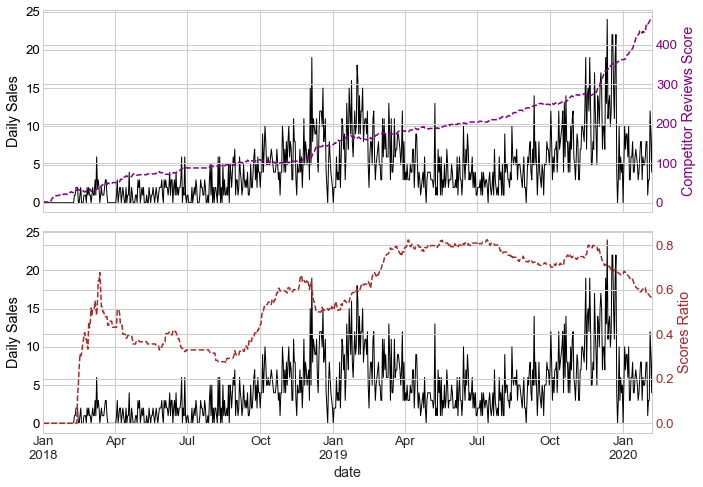

In [122]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

data.quantity.plot(ax=ax[0], color='black', linewidth=1)
ax[0].set_ylabel('Daily Sales', color='black')
ax[0].tick_params(axis='y', labelcolor='black')

ax2 = ax[0].twinx()
data.comp_score_accum.plot(ax=ax2, color='purple', linestyle='--')
ax2.set_ylabel('Competitor Reviews Score', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

data.quantity.plot(ax=ax[1], color='black', linewidth=1)
ax[1].set_ylabel('Daily Sales', color='black')
ax[1].tick_params(axis='y', labelcolor='black')

ax22 = ax[1].twinx()
data.score_ratio.plot(ax=ax22, color='brown', linestyle='--')
ax22.set_ylabel('Scores Ratio', color='brown')
ax22.tick_params(axis='y', labelcolor='brown')

plt.tight_layout()

In [123]:
fig.savefig('outputs/scores.png')

In [44]:
path = Path('data/report/report.csv')
report_raw = pd.read_csv(path, index_col=0)
report_raw = report_raw[['Page Views', 'Sessions']]
report_raw.columns = ['views', 'customers']
report_raw.index = pd.to_datetime(report_raw.index, format="%d/%m/%Y")
report_raw.index.name = 'date'
report_raw.head()

,views,customers
date,,
2018-04-06,41,33
2018-04-07,28,27
2018-04-08,30,24
2018-04-09,30,26
2018-04-10,29,26


In [45]:
data = pd.merge(data, report_raw, how='outer', left_index=True, right_index=True) 
data = data[(data.index >= start_dt) & (data.index <= end_dt)]

data.head()

,price,quantity,advertising,temp_av,score,comp_score,score_accum,comp_score_accum,score_ratio,views,customers
date,,,,,,,,,,,
2018-01-01,24.99,0.0,0.040417,6.833333,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-01-02,24.99,0.0,0.040417,7.722222,0.0,2.0,0.0,2.0,0.0,NaN,NaN
2018-01-03,24.99,0.0,0.040417,9.000000,0.0,0.0,0.0,2.0,0.0,NaN,NaN
2018-01-04,24.99,0.0,0.040417,8.388889,0.0,0.0,0.0,2.0,0.0,NaN,NaN
2018-01-05,24.99,0.0,0.040417,6.166667,0.0,0.0,0.0,2.0,0.0,NaN,NaN


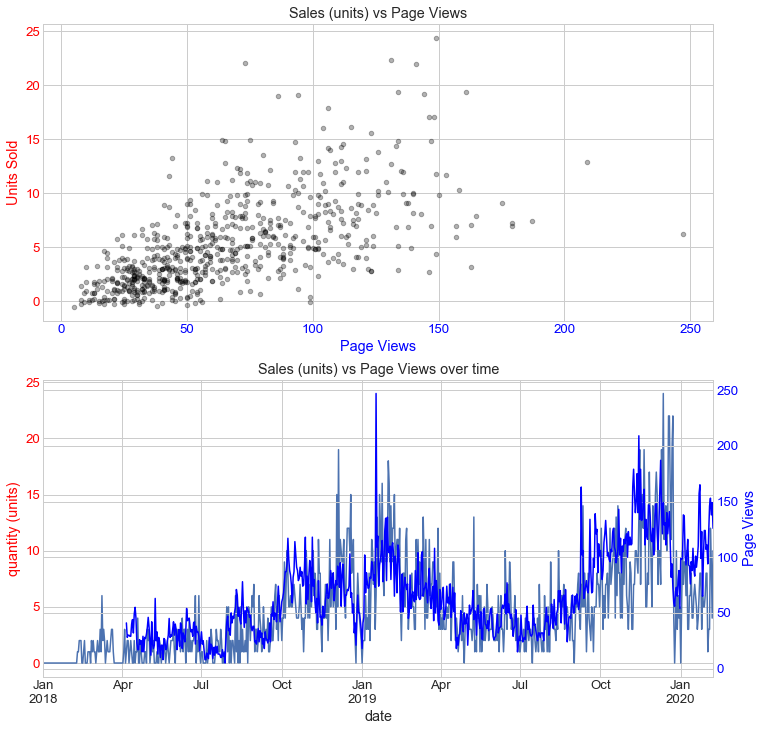

In [46]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].set_title('Sales (units) vs Page Views')
ax[0].scatter(data.views, jitter(data.quantity), s=20, alpha=.3, c='black')
ax[0].set_xlabel('Page Views', color='blue')
ax[0].tick_params(axis='x', labelcolor='blue')
ax[0].set_ylabel('Units Sold', color='red')
ax[0].tick_params(axis='y', labelcolor='red')

ax[1].set_title('Sales (units) vs Page Views over time')

data.quantity.plot(ax=ax[1])
ax[1].set_ylabel('quantity (units)', color='red')
ax[1].tick_params(axis='y', labelcolor='red')

ax2 = ax[1].twinx()
data.views.plot(ax=ax2, color='blue')
ax2.set_ylabel('Page Views', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

In [93]:
data['conversion'] = data.quantity / data.views

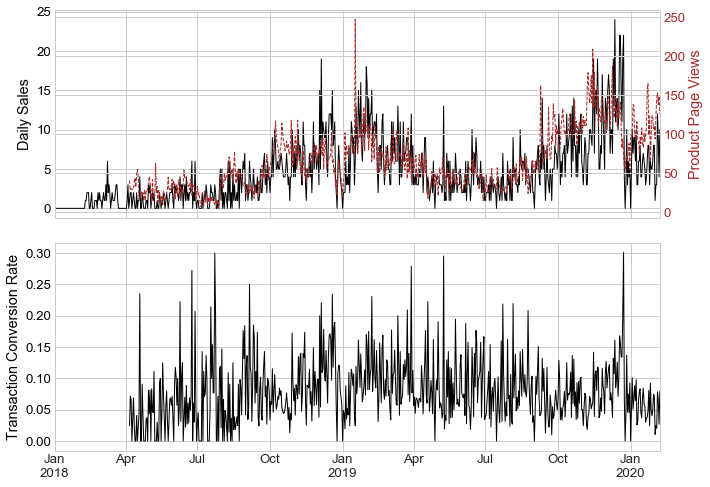

In [114]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7), sharex=True)

data.quantity.plot(ax=ax[0], color='black', linewidth=1)
ax[0].set_ylabel('Daily Sales', color='black')
ax[0].tick_params(axis='y', labelcolor='black')

ax2 = ax[0].twinx()
data.views.plot(ax=ax2, color='brown', linestyle='--', linewidth=1)
ax2.set_ylabel('Product Page Views', color='brown')
ax2.tick_params(axis='y', labelcolor='brown')

ax[0].set_xlabel(None)

data.conversion.plot(ax=ax[1], color='black', linewidth=1)
ax[1].set_ylabel('Transaction Conversion Rate', color='black')
ax[1].tick_params(axis='y', labelcolor='black')

ax[1].set_xlabel(None)

plt.tight_layout()

In [115]:
fig.savefig('outputs/sales-views-time.png')

In [112]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(data.conversion[95:])

0.4932479719952742

In [113]:
from statsmodels.tsa.stattools import adfuller
adfuller(data.conversion[95:])

(-6.855816001778089,
 1.6495833284524364e-09,
 5,
 667,
 {'1%': -3.4401920464204667,
  '5%': -2.865882935271461,
  '10%': -2.569082760711099},
 -2069.003879340922)

In [49]:
data.to_csv('daily_data.csv')

In [50]:
data['week'] = data.index.strftime('%Y_%W')

In [51]:
data_weekly = data.groupby('week').agg({
    'temp_av': 'mean',
    'score': 'mean',
    'score_accum': 'max',
    'comp_score': 'mean',
    'comp_score_accum': 'max',
    'price': 'mean',
    'quantity': 'sum',
    'advertising': 'mean',
    'score_ratio': 'mean',
    'views': 'mean',
    'customers': 'mean'
})

In [52]:
xmas = []
for y in ['2018', '2019']:
    for w in range(50, 53):
        xmas.append(f"{y}_{str(w)}")
data_weekly['xmas'] = data_weekly.index.isin(xmas) * 1

In [53]:
data_weekly['quantity_lag1'] = data_weekly.quantity.shift(-1)
data_weekly['quantity_lag2'] = data_weekly.quantity.shift(-2)
data_weekly['quantity_diff1'] = data_weekly.quantity - data_weekly.quantity_lag1
data_weekly['quantity_diff2'] = data_weekly.quantity_lag1 - data_weekly.quantity_lag2
data_weekly.head(10)

,temp_av,score,score_accum,comp_score,comp_score_accum,price,quantity,advertising,score_ratio,views,customers,xmas,quantity_lag1,quantity_lag2,quantity_diff1,quantity_diff2
week,,,,,,,,,,,,,,,,
2018_01,6.388889,0.000000,0.0,0.285714,2.0,24.990000,0.0,0.040417,0.000000,NaN,NaN,0,0.0,0.0,0.0,0.0
2018_02,5.928571,0.000000,0.0,1.571429,13.0,24.990000,0.0,0.040417,0.000000,NaN,NaN,0,0.0,0.0,0.0,0.0
2018_03,5.468254,0.000000,0.0,1.000000,20.0,24.990000,0.0,0.040417,0.000000,NaN,NaN,0,0.0,0.0,0.0,0.0
2018_04,8.801587,0.000000,0.0,0.285714,22.0,24.990000,0.0,0.040417,0.000000,NaN,NaN,0,0.0,4.0,0.0,-4.0
2018_05,5.611111,0.000000,0.0,0.571429,26.0,24.990000,0.0,0.040417,0.000000,NaN,NaN,0,4.0,7.0,-4.0,-3.0
2018_06,3.380952,0.000000,0.0,0.857143,32.0,24.990000,4.0,0.040417,0.000000,NaN,NaN,0,7.0,5.0,-3.0,2.0
2018_07,4.873016,1.428571,10.0,0.000000,34.0,24.990000,7.0,0.040417,0.211357,NaN,NaN,0,5.0,8.0,2.0,-3.0
2018_08,4.317460,0.142857,11.0,-0.142857,32.0,27.132857,5.0,1.874545,0.374877,NaN,NaN,0,8.0,17.0,-3.0,-9.0
2018_09,-0.007937,0.857143,17.0,0.285714,35.0,28.561429,8.0,2.566308,0.455323,NaN,NaN,0,17.0,8.0,-9.0,9.0


(8.0, 0.0)

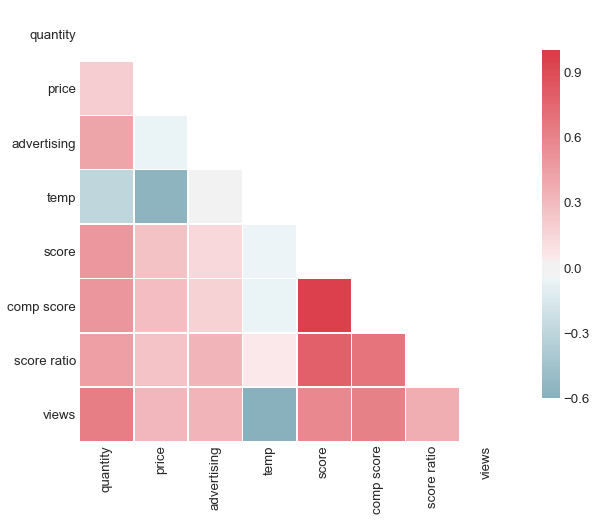

In [77]:
# Compute the correlation matrix
# sns.set(style="ticks")
corr_data = data[
    [
        'quantity',
        'price',
        'advertising',
        'temp_av',
        'score_accum',
        'comp_score_accum',
        'score_ratio',
        'views'
    ]
]
corr_data.columns = ['quantity', 'price', 'advertising', 'temp', 'score', 'comp score', 'score ratio', 'views']
corr = corr_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

fig = plot.get_figure()

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

In [78]:
fig.savefig('outputs/corr.png')

In [87]:
data.quantity.median()

4.0

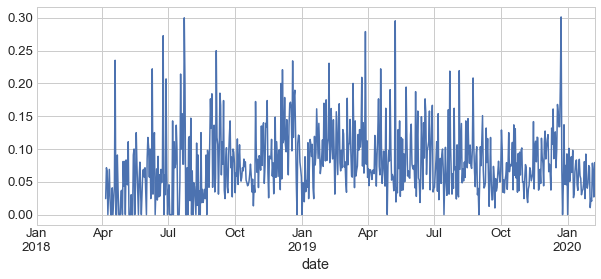

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
data['conversion'] = data.quantity / data.views
data.conversion.plot()

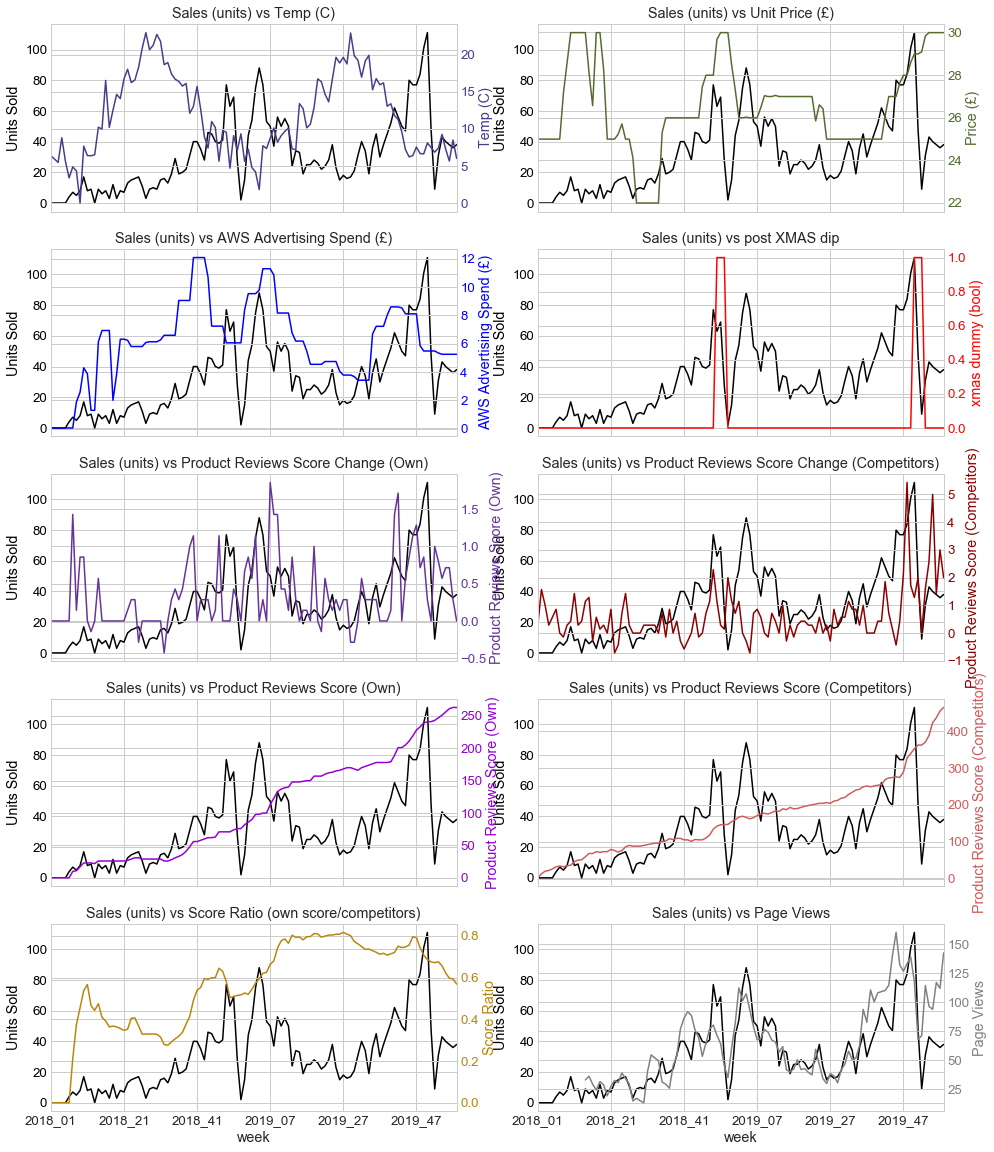

In [55]:
fig, ax = plt.subplots(5, 2, figsize=(16, 20), sharex=True)

ax[0][0].set_title('Sales (units) vs Temp (C)')
data_weekly['quantity'].plot(ax=ax[0][0], c='black')
ax[0][0].set_ylabel('Units Sold', color='black')
ax[0][0].tick_params(axis='y', labelcolor='black')
ax00 = ax[0][0].twinx()
data_weekly['temp_av'].plot(ax=ax00, c='darkslateblue')
ax00.set_ylabel('Temp (C)', color='darkslateblue')
ax00.tick_params(axis='y', labelcolor='darkslateblue')

ax[0][1].set_title('Sales (units) vs Unit Price (£)')
data_weekly['quantity'].plot(ax=ax[0][1], c='black')
ax[0][1].set_ylabel('Units Sold', color='black')
ax[0][1].tick_params(axis='y', labelcolor='black')
ax01 = ax[0][1].twinx()
data_weekly['price'].plot(ax=ax01, c='darkolivegreen')
ax01.set_ylabel('Price (£)', color='darkolivegreen')
ax01.tick_params(axis='y', labelcolor='darkolivegreen')

ax[1][0].set_title('Sales (units) vs AWS Advertising Spend (£)')
data_weekly['quantity'].plot(ax=ax[1][0], c='black')
ax[1][0].set_ylabel('Units Sold', color='black')
ax[1][0].tick_params(axis='y', labelcolor='black')
ax10 = ax[1][0].twinx()
data_weekly['advertising'].plot(ax=ax10, c='blue')
ax10.set_ylabel('AWS Advertising Spend (£)', color='blue')
ax10.tick_params(axis='y', labelcolor='blue')

ax[1][1].set_title('Sales (units) vs post XMAS dip')
data_weekly['quantity'].plot(ax=ax[1][1], c='black')
ax[1][1].set_ylabel('Units Sold', color='black')
ax[1][1].tick_params(axis='y', labelcolor='black')
ax11 = ax[1][1].twinx()
data_weekly['xmas'].plot(ax=ax11, c='red')
ax11.set_ylabel('xmas dummy (bool)', color='red')
ax11.tick_params(axis='y', labelcolor='red')

# reviews change
ax[2][0].set_title('Sales (units) vs Product Reviews Score Change (Own)')
data_weekly['quantity'].plot(ax=ax[2][0], c='black')
ax[2][0].set_ylabel('Units Sold', color='black')
ax[2][0].tick_params(axis='y', labelcolor='black')
ax20 = ax[2][0].twinx()
data_weekly['score'].plot(ax=ax20, c='rebeccapurple')
ax20.set_ylabel('Product Reviews Score (Own)', color='rebeccapurple')
ax20.tick_params(axis='y', labelcolor='rebeccapurple')

ax[2][1].set_title('Sales (units) vs Product Reviews Score Change (Competitors)')
data_weekly['quantity'].plot(ax=ax[2][1], c='black')
ax[2][1].set_ylabel('Units Sold', color='black')
ax[2][1].tick_params(axis='y', labelcolor='black')
ax21 = ax[2][1].twinx()
data_weekly['comp_score'].plot(ax=ax21, c='darkred')
ax21.set_ylabel('Product Reviews Score (Competitors)', color='darkred')
ax21.tick_params(axis='y', labelcolor='darkred')

# reviews 
ax[3][0].set_title('Sales (units) vs Product Reviews Score (Own)')
data_weekly['quantity'].plot(ax=ax[3][0], c='black')
ax[3][0].set_ylabel('Units Sold', color='black')
ax[3][0].tick_params(axis='y', labelcolor='black')
ax30 = ax[3][0].twinx()
data_weekly['score_accum'].plot(ax=ax30, c='darkviolet')
ax30.set_ylabel('Product Reviews Score (Own)', color='darkviolet')
ax30.tick_params(axis='y', labelcolor='darkviolet')

ax[3][1].set_title('Sales (units) vs Product Reviews Score (Competitors)')
data_weekly['quantity'].plot(ax=ax[3][1], c='black')
ax[3][1].set_ylabel('Units Sold', color='black')
ax[3][1].tick_params(axis='y', labelcolor='black')
ax31 = ax[3][1].twinx()
data_weekly['comp_score_accum'].plot(ax=ax31, c='indianred')
ax31.set_ylabel('Product Reviews Score (Competitors)', color='indianred')
ax31.tick_params(axis='y', labelcolor='indianred')

ax[4][0].set_title('Sales (units) vs Score Ratio (own score/competitors)')
data_weekly['quantity'].plot(ax=ax[4][0], c='black')
ax[4][0].set_ylabel('Units Sold', color='black')
ax[4][0].tick_params(axis='y', labelcolor='black')
ax40 = ax[4][0].twinx()
data_weekly['score_ratio'].plot(ax=ax40, c='darkgoldenrod')
ax40.set_ylabel('Score Ratio', color='darkgoldenrod')
ax40.tick_params(axis='y', labelcolor='darkgoldenrod')

# lags
# ax[4][1].set_title('Sales (units) vs Sales Lag1 Diff')
# data_weekly['quantity'].plot(ax=ax[4][1], c='black')
# ax[4][1].set_ylabel('Units Sold', color='black')
# ax[4][1].tick_params(axis='y', labelcolor='black')
# ax41 = ax[4][1].twinx()
# data_weekly['quantity_diff1'].plot(ax=ax41, c='grey')
# ax41.set_ylabel('Lag1 Diff', color='grey')
# ax41.tick_params(axis='y', labelcolor='grey')

ax[4][1].set_title('Sales (units) vs Page Views')
data_weekly['quantity'].plot(ax=ax[4][1], c='black')
ax[4][1].set_ylabel('Units Sold', color='black')
ax[4][1].tick_params(axis='y', labelcolor='black')
ax41 = ax[4][1].twinx()
data_weekly['views'].plot(ax=ax41, c='grey')
ax41.set_ylabel('Page Views', color='grey')
ax41.tick_params(axis='y', labelcolor='grey')

In [56]:
fig.savefig('weekly_data_summary.png')

In [57]:
data_weekly.to_csv('weekly_data.csv')